# SMC in Gen

This document is adapted from the official Gen tutorial: https://www.gen.dev/tutorials/particle-filtering/tutorial

So far, we've seen two general classes of inference algorithm, importance sampling and MCMC.
Very informally, and focusing only on one aspect of the algorithms, we might describe them
as follows:

* *Importance Sampling*: guesses solutions "all at once" using a proposal distribution.
  That proposal may be "smart" (e.g., a data-driven proposal), but still guesses an entire solution
  in one go. We make many guesses, and weight them according to the importance weighting formula.

* *MCMC*: beginning with an initial guess, iteratively refine the guess to explore the space of 
  possible solutions. At every iteration, the current state is an entire proposed solution to the
  problem.

In this notebook, we will explore a third paradigm: **Sequential Monte Carlo**. SMC methods,
such as particle filtering, iteratively solve a *sequence of inference problems* using techniques 
based on importance sampling and in some cases MCMC [1,2]. The solution to each problem in the sequence 
is represented as a collection of samples or *particles*. The particles for each problem are based on 
extending or adjusting the particles for the previous problem in the sequence.

The sequence of inference problems that are solved often arise naturally from
observations that arrive incrementally, as in _particle filtering_. Particle filtering
algorithms are a subclass of SMC algorithms, often applied to state-space models in
which we observe an evolving process over time. We begin by only considering the first
time step, inferring the latent variables at that time step given that time step's
observations. We then consider a slightly more difficult inference problem: joint
inference of the first _two_ time steps' latent variables, given both time steps'
observations. And so on, until the observations stop.

But SMC is a more general algorithm than the particle filter might suggest.
Sometimes, the sequence of problems does not arise from data arriving incrementally,
but is rather constructed instrumentally to facilitate inference, as
in annealed importance sampling [3]. 

However, this notebook focuses on particle filtering for a typical tracking problem.
We show how Gen's support for SMC integrates with its support for MCMC, enabling
"rejuvenation" MCMC moves. Specifically, we will address the
"bearings only tracking" problem described in [4]. 

This notebook will also introduce you to the 
[`Unfold`](https://www.gen.dev/docs/dev/ref/combinators/#Unfold-combinator-1) combinator, 
which can be used to improve performance of SMC.
`Unfold` is just one example of the levers that Gen provides for
improving performance; once you understand it, you can check
Gen's documentation to see how similar principles apply to the 
[`Map`](https://www.gen.dev/docs/dev/ref/combinators/#Map-combinator-1) combinator 
and to the static DSL. (For a deeper dive into the static DSL, consider this tutorial:
[Scaling with Combinators and the Static Modeling Language](https://www.gen.dev/tutorials/scaling-with-combinators-new/tutorial).)



[1] Doucet, Arnaud, Nando De Freitas, and Neil Gordon. "An introduction to sequential Monte Carlo methods." Sequential Monte Carlo methods in practice. Springer, New York, NY, 2001. 3-14.

[2] Del Moral, Pierre, Arnaud Doucet, and Ajay Jasra. "Sequential Monte Carlo samplers." Journal of the Royal Statistical Society: Series B (Statistical Methodology) 68.3 (2006): 411-436.

[3] Neal, Radford M. "Annealed importance sampling." Statistics and computing 11.2 (2001): 125-139.

[4] Gilks, Walter R., and Carlo Berzuini. "Following a moving target—Monte Carlo inference for dynamic Bayesian models." Journal of the Royal Statistical Society: Series B (Statistical Methodology) 63.1 (2001): 127-146. [PDF](http://www.mathcs.emory.edu/~whalen/Papers/BNs/MonteCarlo-DBNs.pdf)

## Outline

**Section 1**: [Implementing the generative model](#basic-model)

**Section 2**: [Implementing a basic particle filter](#basic-pf)

**Section 3**: [Adding rejuvenation moves (i.e., combining SMC and MCMC)](#rejuv)

**Section 4**: [Using the unfold combinator to improve performance](#unfold)

In [1]:
using Gen, Plots

## 1. Implementing the generative model <a name="basic-model"></a>

We will implement a generative model for the movement of a point in the x-y
plane and bearing measurements of the location of this point relative to the
origin over time. We imagine, for example, that we are located at the origin,
and can measure the location of a far-away ship (the object we are tracking) only
by measuring its _bearing_ relative to us, i.e., the angle formed with the x axis
by the ray connecting us to the ship. We would like to infer its (x, y) position
over time.

We assume that we know the approximate initial position and velocity of the
ship. We assume the point's x- and y- velocity are subject to random
perturbations drawn from some normal distribution with a known variance. Each
bearing measurement consists of the angle of the point being tracked relative
to the positive x-axis.

We write the generative model as a generative function below. The function
first samples the initial state of the ship from a prior distribution, and
then generates `T` successive states in a `for` loop. The argument to the
model (`T`) is the number of time steps not including the initial state.


In [2]:
bearing(x, y) = atan(y, x)

@gen function model(T::Int)

    measurement_noise = 0.005
    velocity_var = 1e-6

    xs = Vector{Float64}(undef, T+1)
    ys = Vector{Float64}(undef, T+1)

    # prior on initial x-coordinate
    x = {:x0} ~ normal(0.01, 0.01)

    # prior on initial y-coordinate
    y = {:y0} ~ normal(0.95, 0.01)

    # prior on x-component of initial velocity
    vx = {:vx0} ~ normal(0.002, 0.01)

    # prior on y-component of initial velocity
    vy = {:vy0} ~ normal(-0.013, 0.01)

    # initial bearing measurement
    z0 ~ normal(bearing(x, y), measurement_noise)

    # record position
    xs[1] = x
    ys[1] = y

    # generate successive states and measurements
    for t=1:T

        # update the state of the point
        vx = {(:vx, t)} ~ normal(vx, sqrt(velocity_var))
        vy = {(:vy, t)} ~ normal(vy, sqrt(velocity_var))
        x += vx
        y += vy

        # bearing measurement
        {(:z, t)} ~ normal(bearing(x, y), measurement_noise)

        # record position
        xs[t+1] = x
        ys[t+1] = y
    end

    # return the sequence of positions
    return (xs, ys)
end;

Note that the `model` function itself uses mutation to evolve the variables
`x`, `y`, `vx`, and `vy` over time. The `{addr} ~ distribution()` syntax keeps
the names of traced random variables (for which each address may only be used
once) separate from the names of program variables, like `x`, which may be
reassigned multiple times during the function's execution.

We generate a data set of positions, and observed bearings, by sampling from
this model, with `T=50`:

In [3]:
import Random
Random.seed!(3)

# generate trace with specific initial conditions
T = 50
constraints = Gen.choicemap((:x0, 0.01), (:y0, 0.95), (:vx0, 0.002), (:vy0, -0.013))
(trace, _) = Gen.generate(model, (T,), constraints)

# extract the observed data (zs) from the trace
choices = Gen.get_choices(trace)
zs = Vector{Float64}(undef, T+1)
zs[1] = choices[:z0]
for t=1:T
    zs[t+1] = choices[(:z, t)]
end

We next write a visualization for full traces of this model. It shows the ship's
positions (as dots) as well as the observed bearings (as fixed length line 
segments from the origin):

In [4]:
function render(trace; show_data=true, max_T=get_args(trace)[1], overlay=false)
    (T,) = Gen.get_args(trace)
    (xs, ys) = Gen.get_retval(trace)
    
    zs = Vector{Float64}(undef, T+1)
    zs[1] = trace[:z0]
    for t=1:T
        zs[t+1] = trace[(:z, t)]
    end
    
    f = overlay ? scatter! : scatter
    fig = f(xs[1:max_T+1], ys[1:max_T+1], msize=3, msw=1, label=nothing)
    
    if show_data
        for z in zs[1:max_T+1]
            # render the angular position with a (red) line pointing in that angle
            dx = cos(z) * 0.5
            dy = sin(z) * 0.5
            plot!([0., dx], [0., dy], color="red", alpha=0.3, label=nothing)
        end
    end
    
    return fig
end;

We visualize the synthetic trace below:

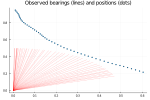

In [5]:
render(trace)
title!("Observed bearings (lines) and positions (dots)")

Note that these are the observed *bearings*, but we are not plotting the
"ground truth" *locations* of the ship. There are many trajectories consistent
with these bearings; for each of the red rays in the above plot, the ship
could be anywhere along the ray (or even slightly off it, given that our
measurements are noisy). However, our assumptions about the dynamics of the
situation &mdash; that is, the conditional distributions $P(x_{t+1}, y_{t+1}
\mid x_t, y_t)$ &mdash; will ensure that physics-defying trajectories (e.g.,
where the ship moves from a very high Y coordinate to a very low one in a
short time) are ruled out.

## 2. Implementing a basic particle filter <a name="basic-pf"></a>

In Gen, a **particle is represented as a trace** and the particle filter
state contains a weighted collection of traces. Below we define an inference
program that runs a particle filter on an observed data set of bearings
(`zs`). We use `num_particles` particles internally, and then we return a
sample of `num_samples` traces from the weighted collection that the particle
filter produces.

Gen provides methods for initializing and updating the state of a particle
filter, documented in [Particle Filtering](https://www.gen.dev/docs/stable/ref/pf/).

- `Gen.initialize_particle_filter`

- `Gen.particle_filter_step!`

Both of these methods can used either with the default proposal or a custom
proposal. In this problem, we will use the default proposal. There is also a method that resamples
particles based on their weights, which serves to redistribute the particles
to more promising parts of the latent space.

- `Gen.maybe_resample!`

Gen also provides a method for sampling a collection of unweighted traces 
(i.e., samples from the posterior that can be used to compute expecations)
from the current weighted collection in the particle filter state:

- `Gen.sample_unweighted_traces`

In [6]:
function particle_filter(num_particles::Int, zs::Vector{Float64}, num_samples::Int)

    # construct initial observations
    init_obs = Gen.choicemap((:z0, zs[1]))
    state = Gen.initialize_particle_filter(model, (0,), init_obs, num_particles)

    # steps
    for t=1:length(zs)-1
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap(((:z, t), zs[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end

    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

The initial state is obtained by providing the following to
`initialize_particle_filter`:

- The generative function for the generative model (`model`)

- The initial arguments to the generative function.

- The initial observations, expressed as a map from choice address to values
  (`init_obs`).

- The number of particles.

At each step, we resample from the collection of traces (`maybe_resample!`)
and then we introduce one additional bearing measurement by calling
`particle_filter_step!` on the state. We pass the following arguments to
`particle_filter_step!`:

- The state (it will be mutated)

- The new arguments to the generative function for this step. In our case,
  this is the number of measurements beyond the first measurement.

- The [argdiff](https://www.gen.dev/docs/dev/ref/gfi/#Argdiffs-1)
  value, which provides detailed information about the change to the
  arguments between the previous step and this step. We will revisit this
  value later.  For now, we indicate that we do not know how the `T::Int`
  argument will change with each step.

- The new observations associated with the new step. In our case, this just
  contains the latest measurement.


We run this particle filter with 5000 particles, and return a sample of 200
particles. This will take 30-60 seconds. We will see one way of speeding up
the particle filter in a later section.

In [7]:
@time pf_traces = particle_filter(5000, zs, 200);

 48.285066 seconds (429.95 M allocations: 13.875 GiB, 37.12% gc time, 1.70% compilation time)


To render these traces, we first define a function that overlays many
renderings:

In [8]:
function overlay(renderer, traces; same_data=true, args...)
    fig = plot(xlabel="X", ylabel="Y",
        title="Observed bearings (red) and \npositions of individual traces (one color per trace)")
    
    renderer(traces[1], show_data=true, overlay=true, args...)
    for i=2:length(traces)
        renderer(traces[i], show_data=!same_data, overlay=true, args...)
    end
    fig
end;

We then render the traces from the particle filter:

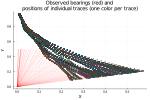

In [9]:
overlay(render, pf_traces)

We see a broad posterior; many trajectories (i.e. x- and y-positions) explain
the observed bearings.

Notice that as during the period of denser bearing measurements, the
trajectories tend to turn so that the heading is more parallel to the bearing
vector. An alternative explanation is that the point maintained a constant
heading, but just slowed down significantly. It is interesting to see that the
inferences favor the "turning explanation" over the "slowing down
explanation".

----

## Exercise
Run the particle filter with fewer particles and visualize the results.

----

## Exercise 

Run the particle filter without the `maybe_resample!` step, and visualize the
results.  What do you observe? Why do you think this is? Answer in the free
response section below.


The code for particle_filter (from above) is copied in the body of the
function below. Modify it so that it does NOT perform resampling after each
time step.

In [8]:
function particle_filter_no_resampling(num_particles::Int, zs::Vector{Float64}, num_samples::Int)

    # construct initial observations
    init_obs = Gen.choicemap((:z0, zs[1]))
    state = Gen.initialize_particle_filter(model, (0,), init_obs, num_particles)

    # steps
    for t=1:length(zs)-1
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap(((:z, t), zs[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end

    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

 65.214568 seconds (429.95 M allocations: 13.868 GiB, 29.38% gc time, 1.59% compilation time)


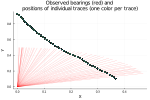

In [9]:
@time pf_traces_no_resampling = particle_filter_no_resampling(5000, zs, 200);
overlay(render, pf_traces_no_resampling)

Describe how the inference differs with and without resampling (based on the two plots above). Why do you think that is? Is it desirable?

----
<!-- 
# BEGIN ANSWER KEY 2.7

function particle_filter_no_resampling(num_particles::Int, zs::Vector{Float64}, num_samples::Int)

    # construct initial observations
    init_obs = Gen.choicemap((:z0, zs[1]))
    state = Gen.initialize_particle_filter(model, (0,), init_obs, num_particles)

    # steps
    for t=1:length(zs)-1
        obs = Gen.choicemap(((:z, t), zs[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end

    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;



# Without resampling, we get particle collapse, because the model converges on
# one best guess. This is not desirable; we have lost diversity in our
# samples.

# END ANSWER KEY -->

## 3. Adding rejuvenation moves <a name="rejuv"></a>

The particle filter we developed above works as follows:

* At the start, guess many possible initial positions and velocities for the
  ship.
* Score these proposals based on the initial observation, `z0`. 
* Use `maybe_resample!` to clone the guesses that explain `z0` well, and cull
  the guesses that explain it poorly.
* For each data point:
    1. For each guess (particle) from the previous time step, guess many possible 
       _extensions_ of the particle to include values of `vx` and `vy` for the next 
       time step.
    2. Score these extended proposed particles based on the latest bearing.
    3. Use `maybe_resample!` to clone the guesses that explain the `z`'s so far, and
       cull the guesses that don't.

A problem with this procedure is that after the initial guesses for a quantity
have been made, they are never revised. This is despite the fact that learning
about later bearings may tell us a lot about earlier positions. This can be
especially problematic in the presence of *resampling*: notice how, in the
above results, the starting locations of all the particles are likely nearly
identical, even though the paths become more diverse as time goes on. This is
because "good" particles at the first step were likely cloned and propagated
through the particle filter, never changing the `x0` and `y0` values.

Therefore, it is sometimes useful to add MCMC moves to particles in a particle
filter between steps. These MCMC moves are often called "rejuvenation moves"
[4].  Each rejuvenation move targets the *current posterior distribution* at
the given step. For example, when applying the rejuvenation move after
incorporating 3 observations, our rejuvenation moves have as their stationary
distribution the conditional distribution on the latent variables, given the
first three observations.

Rejuvenation moves can target any portion of the latent space. It is common
for rejuvenation moves to target "global" variables that affect every time
step (e.g., the initial position of the ship), or a sliding window of _recent_
variables, e.g., the velocities from the previous five time steps. 

In this section, we write two new versions of the particle filter, each of
which uses Metropolis-Hastings rejuvenation moves to adjust each particle at
every time step.  The first version uses so-called "resimulation MH" to adjust
the initial choices (`x0`, `y0`, and the initial velocities). This means that
the proposal distribution for MH is equal to the prior of the generative
model.  The proposed next state under this rejuvenation move is independent of
the current state.  By contrast, the second version we write will use Gaussian
drift proposals, and therefore we refer to it as "random walk MH." The
Gaussian drift rejuvenation moves will target a sliding window of recent
velocities, perturbing them to see if &mdash; in light of new data &mdash; we
can find better values for them.

First, the resimulation MH rejuvenation move (this function is the same as the
previous, but with the addition of a rejuvenation move targeting the initial
choices of each particle):

In [10]:
function particle_filter_rejuv_resim(num_particles::Int, zs::Vector{Float64}, num_samples::Int)
    init_obs = Gen.choicemap((:z0, zs[1]))
    state = Gen.initialize_particle_filter(model, (0,), init_obs, num_particles)
    for t=1:length(zs)-1

        # apply a rejuvenation move to each particle
        for i=1:num_particles
            initial_choices = select(:x0, :y0, :vx0, :vy0)
            state.traces[i], _  = mh(state.traces[i], initial_choices)
        end

        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap(((:z, t), zs[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end

    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

In [ ]:
@time pf_rejuv_resim_traces = particle_filter_rejuv_resim(5000, zs, 200);
overlay(render, pf_rejuv_resim_traces)
title!("Rejuvenation with resimulation MH on the starting points")

You may notice slightly more variety in the initial state, compared to our first round of particle filtering.

----

## Exercise

Write a random walk MH rejuvenation move that perturbs the velocity vectors
for a block of time steps between `a` and `b` inclusive. In this move, draw
the perturbation from a normal distribution with standard deviation `1e-3`.
When sampling a new `vx` and `vy` for time step `t` (where `a <= t <= b`),
make sure you use the right _address_ --- **you want to use the same address
in your proposal as was used in the model.**

We have provided starter code.

In [21]:
@gen function perturbation_proposal(prev_trace, a::Int, b::Int)
    (T,) = get_args(prev_trace)
    speed = Array{Float64}(undef, 2, 1)
    for t=a:b
        speed[1] = 0. # <Remove zero and put your code to perturb vx here>
        speed[2] = 0. # <Remove zero and put your code to perturb vy here>
    end
    return speed # Return an array of the most recent [vx, vy] for testing
end

function perturbation_move(trace, a::Int, b::Int)
    Gen.metropolis_hastings(trace, perturbation_proposal, (a, b))
end;

We add this into our particle filtering inference program below. We apply the
rejuvenation move to adjust the velocities for the previous 5 time steps.

In [22]:
function particle_filter_rejuv(num_particles::Int, zs::Vector{Float64}, num_samples::Int)
    init_obs = Gen.choicemap((:z0, zs[1]))    
    state = Gen.initialize_particle_filter(model, (0,), init_obs, num_particles)
    for t=1:length(zs)-1

        # apply a rejuvenation move to each particle
        for i=1:num_particles
            state.traces[i], _ = perturbation_move(state.traces[i], max(1, t-5), t-1)
        end

        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap(((:z, t), zs[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end

    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

We run the particle filter with rejuvenation below. This will take a minute
or two. We will see one way of speeding up the particle filter in a later
section.

In [23]:
@time pf_rejuv_traces = particle_filter_rejuv(5000, zs, 200);

102.151883 seconds (955.17 M allocations: 31.203 GiB, 22.64% gc time, 0.22% compilation time)


We render the traces:

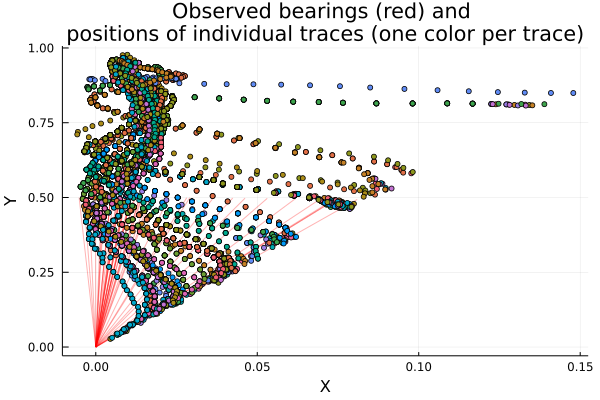

In [24]:
overlay(render, pf_rejuv_traces)
title!("Rejuvenation with resimulation MH on the starting points")

----
<!-- 
@gen function perturbation_proposal(prev_trace, a::Int, b::Int)
    choices = get_choices(prev_trace)
    (T,) = get_args(prev_trace)
    speed = Array{Float64}(undef, 2, 1)
    for t=a:b
        speed[1] = {(:vx, t)} ~ normal(choices[(:vx, t)], 1e-3)
        speed[2] = {(:vy, t)} ~ normal(choices[(:vy, t)], 1e-3)
    end
    return speed
end

function perturbation_move(trace, a::Int, b::Int)
    Gen.metropolis_hastings(trace, perturbation_proposal, (a, b))
end; 
-->

## 4. Using the `Unfold` combinator to improve performance <a name="unfold"></a>

For the particle filtering algorithms above, within an update step it is only
necessary to revisit the most recent state (or the most recent 5 states if
the rejuvenation moves are used) because the initial states are never
updated, and the contribution of these states to the weight computation
cancel.

However, each update step of the particle filter inference programs above
scales *linearly* in the size of the trace because it visits every state when
computing the weight update. This is because the built-in modeling DSL by
default always performs an end-to-end execution of the generative function
body whenever performing a trace update. This allows the built-in modeling
DSL to be very flexible and to have a simple implementation, at the cost of
performance. There are several ways of improving performance after one has a
prototype written in the built-in modeling DSL. One of these is [Generative
Function Combinators](https://www.gen.dev/docs/dev/ref/combinators/), which make 
the flow of information through the generative process more explicit to Gen, 
and enable asymptotically more efficient inference programs.

To exploit the opportunity for incremental computation, and improve the
scaling behavior of our particle filter inference programs, we will write a
new model using a generative function combinator to replaces the following 
Julia `for` loop in our model.

```julia
    # generate successive states and measurements
    for t=1:T

        # update the state of the point
        vx = {(:vx, t)} ~ normal(vx, sqrt(velocity_var))
        vy = {(:vy, t)} ~ normal(vy, sqrt(velocity_var))
        x += vx
        y += vy

        # bearing measurement
        {(:z, t)} ~ normal(bearing(x, y), measurement_noise)

        # record position
        xs[t+1] = x
        ys[t+1] = y
    end
```

This `for` loop has a very specific pattern of information flow&mdash;there is a
sequence of states (represented by `x`, `y`, `vx`, and `vy`), and each state is
generated from the previous state. This is exactly the pattern that the
[Unfold](https://www.gen.dev/docs/dev/ref/combinators/#Unfold-combinator-1)
generative function combinator is designed to handle.

Below, we re-express the Julia `for` loop over the state sequence using the
Unfold combinator. Specifically, we define a generative function (`kernel`)
that takes the prevous state as its second argument, and returns the new
state. The Unfold combinator takes the kernel and returns a new generative
function (`chain`) that applies kernel repeatedly. Read the Unfold combinator
documentation for details on the behavior of the resulting generative
function (`chain`).

In [10]:
struct State
    x::Float64
    y::Float64
    vx::Float64
    vy::Float64
end

@gen (static) function kernel(t::Int, prev_state::State,
                              velocity_var::Float64, measurement_noise::Float64)
    vx ~ normal(prev_state.vx, sqrt(velocity_var))
    vy ~ normal(prev_state.vy, sqrt(velocity_var))
    x = prev_state.x + vx
    y = prev_state.y + vy
    z ~ normal(bearing(x, y), measurement_noise)
    next_state = State(x, y, vx, vy)
    return next_state
end

chain = Gen.Unfold(kernel)

Gen.@load_generated_functions # To allow use of the generative function written in the static modeling language above.

We can understand the behavior of `chain` by getting a trace of it and
printing the random choices:

In [11]:
trace = Gen.simulate(chain, (4, State(0., 0., 0., 0.), 0.01, 0.01))
Gen.get_choices(trace)

│
├── 1
│   │
│   ├── :vx : 0.15346338480825963
│   │
│   ├── :vy : 0.026731161406923994
│   │
│   └── :z : 0.1627586045937651
│
├── 2
│   │
│   ├── :vx : 0.13948424586420005
│   │
│   ├── :vy : 0.010003333737733613
│   │
│   └── :z : 0.12433983973494785
│
├── 3
│   │
│   ├── :vx : 0.10238450582351309
│   │
│   ├── :vy : 0.04238617711785753
│   │
│   └── :z : 0.1953655066140093
│
└── 4
    │
    ├── :vx : 0.14709089813127818
    │
    ├── :vy : 0.17613929257467237
    │
    └── :z : 0.4403610691311898


We now write a new version of the generative model that invokes `chain`
instead of using the Julia `for` loop:

In [12]:
@gen (static) function unfold_model(T::Int)

    # parameters
    measurement_noise = 0.005
    velocity_var = 1e-6

    # initial conditions
    x0  ~ normal(0.01, 0.01)
    y0  ~ normal(0.95, 0.01)
    vx0 ~ normal(0.002, 0.01)
    vy0 ~ normal(-0.013, 0.01)

    # initial measurement
    z0 ~ normal(bearing(x0, y0), measurement_noise)

    # record initial state
    init_state = State(x0, y0, vx0, vy0)

    # run `chain` function under address namespace `:chain`, producing a vector of states
    chain ~ chain(T, init_state, velocity_var, measurement_noise)

    result = (init_state, chain)
    return result
end;

Gen.@load_generated_functions

Let's generate a trace of this new model program to understand its structure:

In [13]:
(trace, _) = Gen.generate(unfold_model, (4,))
Gen.get_choices(trace)

│
├── :x0 : 0.01707215646469002
│
├── :y0 : 0.9442123173595948
│
├── :vx0 : 0.0023382685162061296
│
├── :vy0 : -0.02579085820614882
│
├── :z0 : 1.5523644379852244
│
└── :chain
    │
    ├── 1
    │   │
    │   ├── :vx : 0.0004293022294187647
    │   │
    │   ├── :vy : -0.02693286948829094
    │   │
    │   └── :z : 1.555303889650695
    │
    ├── 2
    │   │
    │   ├── :vx : 0.001432167034897278
    │   │
    │   ├── :vy : -0.024917516973453818
    │   │
    │   └── :z : 1.5548574140924676
    │
    ├── 3
    │   │
    │   ├── :vx : 0.002411483802752497
    │   │
    │   ├── :vy : -0.026227046404853762
    │   │
    │   └── :z : 1.555386711526417
    │
    └── 4
        │
        ├── :vx : 0.0028793106291302084
        │
        ├── :vy : -0.026453344197644287
        │
        └── :z : 1.5380030560058877


We can now run a particle filter on the Unfold model and see a speedup:

In [14]:
function unfold_particle_filter(num_particles::Int, zs::Vector{Float64}, num_samples::Int)
    init_obs = Gen.choicemap((:z0, zs[1]))
    state = Gen.initialize_particle_filter(unfold_model, (0,), init_obs, num_particles)
    
    for t=1:length(zs)-1
        maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap((:chain => t => :z, zs[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end

    # return a sample of traces from the weighted collection:
    return Gen.sample_unweighted_traces(state, num_samples)
end;

In [15]:
@time unfold_pf_traces = unfold_particle_filter(5000, zs, 200);

  8.719837 seconds (37.10 M allocations: 3.415 GiB, 27.97% gc time, 35.98% compilation time)


In [16]:
function unfold_render(trace; show_data=true, max_T=get_args(trace)[1], overlay=false)
    (T,) = Gen.get_args(trace)
    choices = Gen.get_choices(trace)
    (init_state, states) = Gen.get_retval(trace)
    xs = Vector{Float64}(undef, T+1)
    ys = Vector{Float64}(undef, T+1)
    zs = Vector{Float64}(undef, T+1)
    xs[1] = init_state.x
    ys[1] = init_state.y
    zs[1] = choices[:z0]
    for t=1:T
        xs[t+1] = states[t].x
        ys[t+1] = states[t].y
        zs[t+1] = choices[:chain => t => :z]
    end
    f = overlay ? scatter! : scatter
    fig = f(xs[1:max_T+1], ys[1:max_T+1], msize=3, msw=1, label=nothing)
    if show_data
        for z in zs[1:max_T+1]
            dx = cos(z) * 0.5
            dy = sin(z) * 0.5
            plot!([0., dx], [0., dy], color="red", alpha=0.3, label=nothing)
        end
    end
end;

Let's check that the results are reasonable:

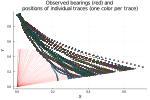

In [17]:
overlay(unfold_render, unfold_pf_traces, same_data=true)

We now empirically investigate the scaling behavior of 
1. the inference program that uses the Julia `for` loop (`particle_filter`),
and 
2. the equivalent inference program that uses `Unfold`
(`unfold_particle_filter`). 

We will use a synthetic long vector of z data, and we will investigate how the
running time depends on the number of observations.

In [ ]:
fake_zs = rand(1000);

function timing_experiment(num_observations_list::Vector{Int}, num_particles::Int, num_samples::Int)
    times = Vector{Float64}()
    times_unfold = Vector{Float64}()
    for num_observations in num_observations_list
        println("evaluating inference programs for num_observations: $num_observations")
        tstart = time_ns()
        traces = particle_filter(num_particles, fake_zs[1:num_observations], num_samples)
        push!(times, (time_ns() - tstart) / 1e9)
        
        tstart = time_ns()
        traces = unfold_particle_filter(num_particles, fake_zs[1:num_observations], num_samples)
        push!(times_unfold, (time_ns() - tstart) / 1e9)
        
    end
    (times, times_unfold)
end;

num_observations_list = [1, 3, 10, 30, 50, 100, 150, 200, 500]
(times, times_unfold) = timing_experiment(num_observations_list, 100, 20);

evaluating inference programs for num_observations: 1
evaluating inference programs for num_observations: 3
evaluating inference programs for num_observations: 10
evaluating inference programs for num_observations: 30
evaluating inference programs for num_observations: 50
evaluating inference programs for num_observations: 100
evaluating inference programs for num_observations: 150
evaluating inference programs for num_observations: 200


Notice that the running time of the inference program without unfold appears to be quadratic in the number of observations, whereas the inference program that uses unfold appears to scale linearly:

In [ ]:
plot(num_observations_list, times, color="blue", 
    xlabel="# observations", ylabel="running time (sec.)", label="for loop")
plot!(num_observations_list, times_unfold, color="red", label="unfold")